In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import pickle
import os

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 125)

In [4]:
model_path_name = "nn_single_model"
DIRECTORY_PATH = f"models/{model_path_name}"
MODEL_INFO_FILEPATH = f"{DIRECTORY_PATH}/info.txt"

if not os.path.exists(DIRECTORY_PATH):
    os.makedirs(DIRECTORY_PATH)
with open(MODEL_INFO_FILEPATH, "w") as text_file:
    print(f"##### MODEL INFO #####", file=text_file)

In [5]:
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device('cpu')
print(f"Using device = {DEVICE}")

Using device = mps


In [6]:
dataset = pd.read_pickle("data/advanced_dataset_final.pkl")
dataset.top = dataset.top.astype(int)

In [7]:
dataset_dummied = pd.get_dummies(dataset, columns=['inning', 'p_throws', 'bases_state', 'stand', 'prev_pitch_type', 'prev_type'], dummy_na=False, drop_first=True)
cols_with_nan = dataset_dummied.columns[dataset_dummied.isna().any()].tolist()
# Iterate over the columns that have NaN values
for col in cols_with_nan:
    # Create a new column with the column name appended with '_nan'
    new_col_name = col + '_is_nan'
    # Create the new column by checking if the values in the original column are NaN
    dataset_dummied[new_col_name] = dataset_dummied[col].isna().astype(int)


In [8]:
dataset_dummied.fillna(-99, axis=1, inplace=True)

In [9]:
dataset_dummied.to_pickle("data/dummy_dataset.pkl")

In [10]:
mapping = {'FF' : 0,
           'SL': 1, 
           'CU': 2, 
           'SI': 3, 
           'FC': 4, 
           'FT': 5, 
           'KC': 6, 
           'CH': 7, 
           'KN': 8, 
           'FS': 9, 
           'FO': 10, 
           'EP': 11, 
           'SC': 12}

In [11]:
train_index_stop = 569484 # this is the first index of a new pitcher
val_index_stop = 640690 # make sure no overlapping plays

training_set = dataset_dummied.iloc[0:train_index_stop, :]
validation_set = dataset_dummied.iloc[train_index_stop:val_index_stop, :]
test_set = dataset_dummied.iloc[val_index_stop:,]

train_X = torch.tensor(training_set.drop(["uid", "pitch_type", "type_confidence", "pitcher_id"],axis=1).values.astype(float)).float()
train_y = training_set['pitch_type']
train_weights = torch.tensor(training_set['type_confidence'].values.astype(np.float32))

val_X = torch.tensor(validation_set.drop(["uid", "pitch_type", "type_confidence", "pitcher_id"],axis=1).values.astype(float)).float()
val_y = validation_set['pitch_type']
val_weights = torch.tensor(validation_set['type_confidence'].values.astype(np.float32))

test_X = torch.tensor(test_set.drop(["uid", "pitch_type", "type_confidence", "pitcher_id"],axis=1).values.astype(float)).float()
test_y = test_set['pitch_type']
test_weights = torch.tensor(test_set['type_confidence'].values.astype(np.float32))

train_y = torch.tensor(train_y.map(mapping).values.astype(np.float32)).type(torch.LongTensor)
val_y = torch.tensor(val_y.map(mapping).values.astype(np.float32)).type(torch.LongTensor)
test_y = torch.tensor(test_y.map(mapping).values.astype(np.float32)).type(torch.LongTensor)

In [13]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.x = X
        self.y = y
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        X = self.x[idx]
        y = self.y[idx]
        return X, y

In [69]:
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 0}
training_dataset = CustomDataset(train_X, train_y)
training_generator = torch.utils.data.DataLoader(training_dataset, **params)
validation_dataset = CustomDataset(val_X, val_y)
validation_generator = torch.utils.data.DataLoader(validation_dataset, **params)
test_dataset = CustomDataset(test_X, test_y)
test_generator = torch.utils.data.DataLoader(test_dataset, **params)

In [94]:
class PitchModel(nn.Module):
    def __init__(self, num_outputs=13, feature_input_size=217):
        super(PitchModel, self).__init__()

        self.feature_input_size = feature_input_size
        self.num_outputs = num_outputs

        self.fc1 = nn.Linear(self.feature_input_size, 2000)
        self.fc2 = nn.Linear(2000, 1000)
        self.fc3 = nn.Linear(1000, 300)
        self.fc4 = nn.Linear(300, self.num_outputs)

        self.relu = nn.ReLU()

    def forward(self, x):
        out1 = self.relu(self.fc1(x))
        out2 = self.relu(self.fc2(out1))
        out3 = self.relu(self.fc3(out2))
        logits = self.fc4(out3)
        return logits

In [95]:
def train_one_epoch(loss_history, dataloader, optimizer, model, loss_fn):
    running_loss = 0
    last_loss = 0

    for i, (batch_X, batch_y) in enumerate(dataloader):
        # Every data instance is an input + label pair
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Make predictions for this batch
        outputs = model(batch_X)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        loss_history.append(loss.item())
        running_loss += loss.item()
        if i % 750 == 0:
            _, predicted = torch.max(outputs, 1)
            total = batch_y.size(0)
            correct = (predicted == batch_y).sum().item()

            last_loss = running_loss / 750 # loss per batch
            print(f" batch {i}: loss = {last_loss}, Acc% = {correct/total}")
            running_loss = 0
    return last_loss

In [96]:
def train_model(epochs, train_loss_hist, val_loss_hist, model, optimizer, criterion, train_gen, val_gen):

    for e in range(epochs):
        print(f"######## Epoch {e}: ############")
        model.train(True)
        last_train_batch_loss = train_one_epoch(train_loss_hist, train_gen, optimizer, model, criterion)

        model.eval()
        running_val_loss = 0
        correct = 0
        total = 0
        for batch_idx, (batch_X, batch_y) in enumerate(val_gen):
            with torch.no_grad():
                pred_y = model(batch_X)

                _, predicted = torch.max(pred_y, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

                val_batch_loss = criterion(pred_y, batch_y)
                running_val_loss += val_batch_loss
                val_loss_hist.append(val_batch_loss.item())
        avg_val_loss = running_val_loss/len(val_gen)
        val_accuracy = correct/total
        print(f'Last train (avg batch) loss = {last_train_batch_loss}, Avg Val Loss = {avg_val_loss}, Val Acc% = {val_accuracy}')

    return train_loss_hist, val_loss_hist

In [97]:
def accuracy(dataloader, model):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for x,y in dataloader:
            # calculate outputs by running images through the network
            outputs = model(x)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct/total

In [98]:
LEARNING_RATE = 3e-4
NUM_EPOCHS = 150
model = PitchModel(num_outputs=13, feature_input_size=217)
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_loss_hist = []
val_loss_hist = []

In [99]:
train_loss_hist, val_loss_hist = train_model(NUM_EPOCHS, train_loss_hist, val_loss_hist, model, optimizer, criterion, training_generator, validation_generator)


######## Epoch 0: ############
 batch 0: loss = 0.011702999114990235, Acc% = 0.09375
 batch 750: loss = 2.143083478609721, Acc% = 0.3359375
 batch 1500: loss = 1.7643412246704102, Acc% = 0.36328125
Last train (avg batch) loss = 1.7643412246704102, Avg Val Loss = 1.5378103256225586, Val Acc% = 0.4596522764935539
######## Epoch 1: ############
 batch 0: loss = 0.002052007516225179, Acc% = 0.41796875
 batch 750: loss = 1.553697543303172, Acc% = 0.42578125
 batch 1500: loss = 1.5076957046190897, Acc% = 0.53125
Last train (avg batch) loss = 1.5076957046190897, Avg Val Loss = 1.4741963148117065, Val Acc% = 0.46840153919613514
######## Epoch 2: ############
 batch 0: loss = 0.001963520685831706, Acc% = 0.46875
 batch 750: loss = 1.4610898626645406, Acc% = 0.4921875
 batch 1500: loss = 1.4387768972714743, Acc% = 0.484375
Last train (avg batch) loss = 1.4387768972714743, Avg Val Loss = 1.3806734085083008, Val Acc% = 0.4769541892537146
######## Epoch 3: ############
 batch 0: loss = 0.0019794079

In [ ]:
# at 300 epochs

In [61]:
torch.save(model, f'models/nn_single_model/model.pth')

<Axes: >

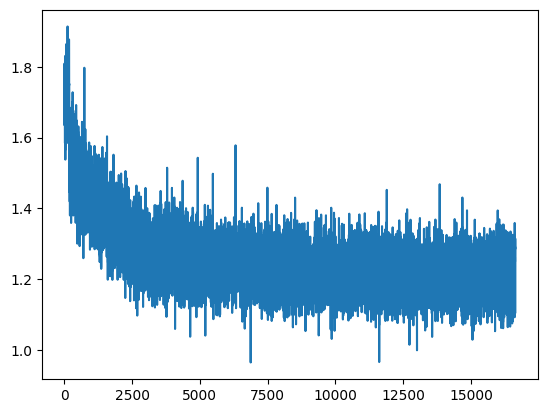

In [57]:
pd.Series(val_loss_hist[100:]).plot()

<Axes: >

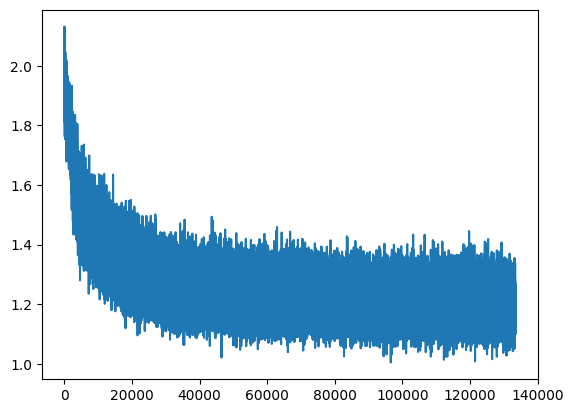

In [56]:
pd.Series(train_loss_hist[100:]).plot()

In [65]:
accuracy(test_generator, model)

0.4904639428820396